In [836]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import datetime
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [837]:
df = pd.read_csv("clean_data.csv", index_col=0)
df

,required_age,price,relase_year,Violent,Adventure,RPG,Action,Sports,Simulation,Racing,...,Includes level editor,Co-op,Commentary available,Additional High-Quality Audio,Steam Cloud,Steam Workshop,mac,linux,windows,score
0,0,1379,2021,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0.955032
1,0,399,2021,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.733668
2,0,499,2021,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0.921053
3,0,5999,2022,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0.953191
4,0,799,2021,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.971429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,599,2017,0,0,1,1,0,0,0,...,0,0,0,0,1,0,1,1,1,0.921875
9996,0,1679,2020,0,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.660407
9997,0,4999,2020,0,0,1,1,1,0,0,...,0,1,1,0,1,0,0,0,1,0.677665
9998,0,1999,2017,0,1,1,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0.973799


# Correlation distribution

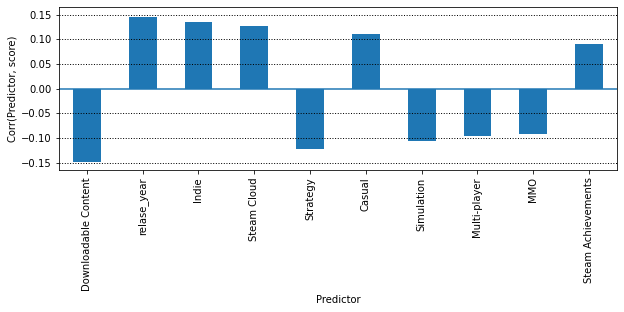

In [838]:
plt.figure(figsize=(10,3))
plt.axhline(0)
for i in [-0.15, -0.1, -0.05, 0.05, 0.1, 0.15]:
    plt.axhline(i, color = "black", linestyle=':', linewidth = 1)

plt.xlabel("Predictor")
plt.ylabel("Corr(Predictor, score)")
bars = bars = df.corr()['score'][df.corr()['score'].abs().sort_values(ascending=False).index][range(1,11)].plot(kind='bar')
plt.savefig('corr_dist.png', dpi=300, bbox_inches="tight")

# MLR

In [839]:
def find_predictors(df):
    
    # Sort by absolute correlation
    predictors = abs(df.corr()['score']).sort_values(ascending=False).drop("score")

    r2_max = 0
    i_max = 0

    # add variables until model is overfitting
    for i, col in enumerate(list(predictors.index)):
        X = df[predictors.index[:i+1]]
        X_train, X_test, y_train, y_test = train_test_split(X, df["score"], test_size=0.3, random_state=42)
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2 > r2_max:
            r2_max = r2
            i_max = i+1

    # return predictors
    return predictors[0:i_max] 


In [840]:
# train again best model
predictors  = find_predictors(df)
X_train, X_test, y_train, y_test = train_test_split(df[list(predictors.index)], df["score"], test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

len(predictors), round(r2, 5), round(MSE, 5), round(explained_var,5)

(37, 0.11682, 0.02129, 0.11682)

## Check correlation between independent variables

In [841]:
corr = df.iloc[:,0:-1].corr()
high_corr1, high_corr2 = np.where(np.abs(corr)>0.5)
# get indicics of highly correlated features in feature matrix
A = []
for i in range(len(high_corr1)):
    if high_corr1[i]!=high_corr2[i]:
        A.append((high_corr1[i],high_corr2[i]))
        
# transform indices to names of columns, add to tuple together with correlation of the features
B = []
for i in range(len(A)):
    B.append((df.columns[A[i][0]],df.columns[A[i][1]], round(corr.iloc[A[i][0],A[i][1]],3)))
    
# transform indices to names of columns, add to tuple together with correlation of the features
B = []
for i in range(len(A)):
    B.append((df.columns[A[i][0]],df.columns[A[i][1]], round(corr.iloc[A[i][0],A[i][1]],3)))
B
    

[('Nudity', 'Sexual Content', 0.572),
 ('Sexual Content', 'Nudity', 0.572),
 ('Multi-player', 'PvP', 0.632),
 ('Multi-player', 'Co-op', 0.653),
 ('LAN Co-op', 'LAN PvP', 0.621),
 ('PvP', 'Multi-player', 0.632),
 ('LAN PvP', 'LAN Co-op', 0.621),
 ('Includes level editor', 'Steam Workshop', 0.507),
 ('Co-op', 'Multi-player', 0.653),
 ('Steam Workshop', 'Includes level editor', 0.507),
 ('mac', 'linux', 0.654),
 ('linux', 'mac', 0.654)]

## Histograms conditioned on MMO, Indie and release_year

(array([2.04185809e-03, 2.04185809e-03, 3.26697295e-02, 3.67534456e-02,
        4.69627361e-02, 9.39254722e-02, 1.49055641e-01, 1.73557938e-01,
        2.53190403e-01, 3.04236856e-01, 5.10464523e-01, 6.55436447e-01,
        8.90250128e-01, 1.19244513e+00, 1.61919347e+00, 2.20316488e+00,
        2.66870852e+00, 3.15262889e+00, 3.63450740e+00, 2.37876468e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

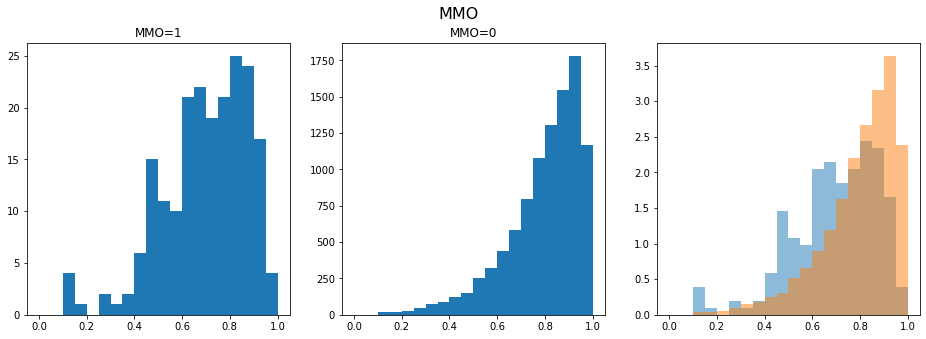

In [842]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('MMO', fontsize=16)
ax1.hist(df.loc[df['MMO'] == 1]["score"],bins)
ax2.hist(df.loc[df["MMO"] == 0]["score"],bins)
ax1.set_title("MMO=1")
ax2.set_title("MMO=0")
ax3.hist(df.loc[df['MMO'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df["MMO"] == 0]["score"],bins, density=True, alpha=0.5)

confirm with Whitney U-Test:

In [843]:
stats.mannwhitneyu(df.loc[df["MMO"] == 0]["score"], df.loc[df['MMO'] == 1]["score"],alternative="less")

MannwhitneyuResult(statistic=1368567.0, pvalue=1.0)

whitneyu provides evidence that distribution of MMO=1 is NOT higher than distribution of MMO=0.

(array([2.23588597e-03, 2.23588597e-03, 2.90665176e-02, 2.45947457e-02,
        3.13024036e-02, 7.82560089e-02, 1.20737842e-01, 1.38624930e-01,
        2.28060369e-01, 2.90665176e-01, 4.38233650e-01, 6.19340414e-01,
        9.03297932e-01, 1.20290665e+00, 1.62101733e+00, 2.18893236e+00,
        2.70542202e+00, 3.21296814e+00, 3.74734489e+00, 2.41475685e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

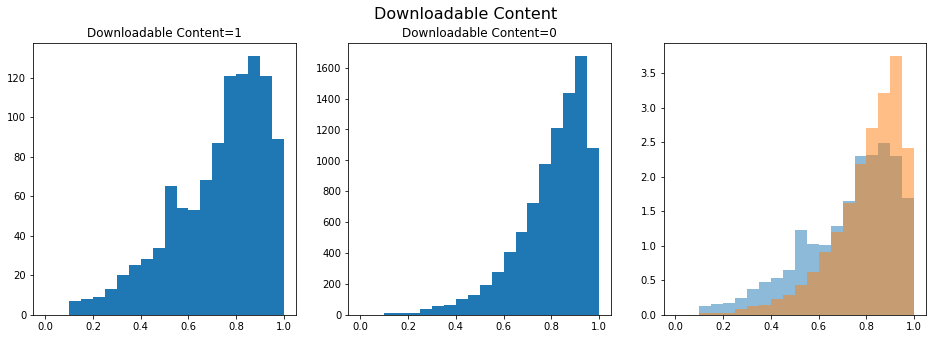

In [844]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('Downloadable Content', fontsize=16)
ax1.hist(df.loc[df['Downloadable Content'] == 1]["score"],bins)
ax2.hist(df.loc[df['Downloadable Content'] == 0]["score"],bins)
ax1.set_title("Downloadable Content=1")
ax2.set_title("Downloadable Content=0")
ax3.hist(df.loc[df['Downloadable Content'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df['Downloadable Content'] == 0]["score"],bins, density=True, alpha=0.5)

(array([0.00516529, 0.00516529, 0.08780992, 0.06198347, 0.08780992,
        0.15495868, 0.20144628, 0.25309917, 0.30475207, 0.4803719 ,
        0.73863636, 0.79028926, 1.07438017, 1.24483471, 1.70454545,
        2.23140496, 2.74793388, 3.01136364, 3.00619835, 1.80785124]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

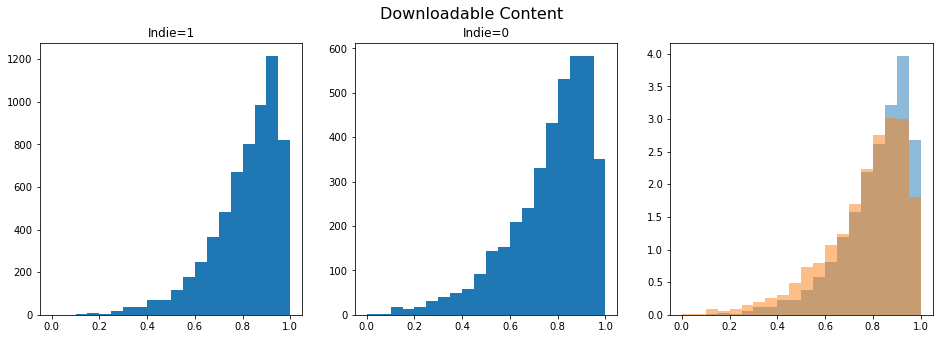

In [845]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('Downloadable Content', fontsize=16)
ax1.hist(df.loc[df['Indie'] == 1]["score"],bins)
ax2.hist(df.loc[df['Indie'] == 0]["score"],bins)
ax1.set_title('Indie=1')
ax2.set_title('Indie=0')
ax3.hist(df.loc[df['Indie'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df['Indie'] == 0]["score"],bins, density=True, alpha=0.5)

In [846]:
stats.mannwhitneyu(df.loc[df['Indie'] == 0]["score"], df.loc[df['Indie'] == 1]["score"], alternative="less")

MannwhitneyuResult(statistic=10105239.0, pvalue=3.482767775659832e-36)

Whitneyu provides evidence that Indie games are better than non-indie games

In [847]:
A = np.zeros(len(set(df["relase_year"])))
for i in range(len(set(df["relase_year"]))):
    A[i] = np.mean(df.loc[lambda df: df.relase_year == 1998+i,"score"])
    

Text(0.5, 1.0, 'average game-score by release year')

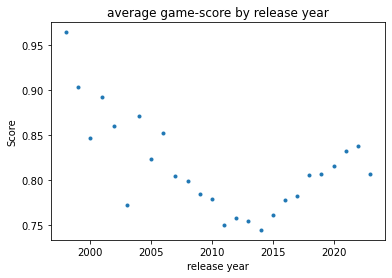

In [848]:
plt.plot(A,".")
plt.ylabel("Score")
plt.xlabel("release year")
plt.xticks([2,7,12,17,22],labels=["2000","2005", "2010", "2015", "2020"])
plt.title("average game-score by release year")

From the looks of it, games seem to have been better (rated) in the past. However, the plot is to be enjoyed with caution,
e.g. for the years 1998,1999 are only 1-2 games in the data set.

# NN approach

In [849]:
# standardize data before using it as NN input
df_stand = df.copy(deep=True)
age = df["required_age"]
df_stand["required_age"] = (age-np.mean(age))/np.std(age)
price = np.array(df["price"]).reshape(-1)
df_stand["price"] = (price-np.mean(price))/np.std(price)
year = df["relase_year"]
year = df["relase_year"]
df_stand["relase_year"] = (year-np.mean(year))/np.std(year)

In [850]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))

In [851]:
class SteamData(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.data_size = len(self.df)
        self.num_variables = len(self.df.columns[0:-1])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        IVs = torch.from_numpy(np.array(self.df.iloc[idx,0:-1],dtype=np.double))
        target = torch.from_numpy(np.array(self.df.loc[idx,"score"], dtype=np.double))
        
        sample = (IVs,target)
        return sample

In [852]:
Dataloader_steam = SteamData(df_stand)

BATCHSIZE = 64

generator=torch.Generator().manual_seed(42)

train_size = int(0.7 * len(df_stand))
test_size = len(df_stand) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(Dataloader_steam, [train_size, test_size], generator =generator)

SteamData_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE,
shuffle=True)

SteamData_val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE,
shuffle=False)

In [853]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.leaky_relu(self.lin1(x))
        out = F.leaky_relu(self.lin2(out))
        out = F.leaky_relu(self.lin3(out))
        out = torch.sigmoid(self.lin4(out))
        return out

In [854]:
model = NN()
model = model.to(device=device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
model.train()
n_epochs = 20

In [855]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_train = np.array(n_epochs)
    loss_val = np.array(n_epochs)
    for epoch in range(1,n_epochs+1):
        model.train()
        total_loss_train = 0
        total_loss_val = 0
        for IV, score in train_loader:
            IV = IV.to(device=device)
            score = score.to(device=device)
            outputs = model(IV)
            loss_train = loss_fn(outputs.flatten(), score)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
            total_loss_train+=loss_train
        
        for IV, score in val_loader:
            model.eval()
            with torch.no_grad():
                IV = IV.to(device=device)
                score = score.to(device=device)
                outputs = model(IV)
                loss_val = loss_fn(outputs.flatten(), score)
                
                total_loss_val+=loss_val
       
            
            

        if epoch ==1 or epoch % 1 == 0:
            print("{} Epoch {}, Training loss {}, Validation Loss: {}".format(
            datetime.datetime.now(), epoch,
            total_loss_train/ len(train_loader), total_loss_val/len(val_loader)))

In [856]:
training_loop(n_epochs, optimizer, model, loss_fn, SteamData_train_loader, SteamData_val_loader)

2023-01-27 21:28:37.432081 Epoch 1, Training loss 0.05980911665245037, Validation Loss: 0.024747412162647458
2023-01-27 21:28:40.321833 Epoch 2, Training loss 0.023374618374790226, Validation Loss: 0.022667665003861404
2023-01-27 21:28:43.252664 Epoch 3, Training loss 0.02210133572746678, Validation Loss: 0.02186966113097736
2023-01-27 21:28:46.258209 Epoch 4, Training loss 0.021297465926227235, Validation Loss: 0.021371052162080215
2023-01-27 21:28:49.255591 Epoch 5, Training loss 0.02073914856917142, Validation Loss: 0.021008627723341753
2023-01-27 21:28:52.323229 Epoch 6, Training loss 0.02024734679031741, Validation Loss: 0.020791287179368883
2023-01-27 21:28:55.277159 Epoch 7, Training loss 0.019978423763742995, Validation Loss: 0.0206847341785746
2023-01-27 21:28:58.034367 Epoch 8, Training loss 0.01978940587899275, Validation Loss: 0.0205830023352172
2023-01-27 21:29:01.161637 Epoch 9, Training loss 0.01951138727372216, Validation Loss: 0.020485886390439682
2023-01-27 21:29:04.0

## Check testset with NN model

In [857]:
test_samples = np.zeros((len(SteamData_val_loader.dataset),53))
test_samples_score = np.zeros(len(SteamData_val_loader.dataset))
idx=0
for IV,score in SteamData_val_loader:
    test_samples[idx:idx+IV.shape[0]] = IV
    test_samples_score[idx:idx+IV.shape[0]] = score
    idx=idx+IV.shape[0]
test_samples = (torch.from_numpy(test_samples)).to(device)
with torch.no_grad():
    y_pred_NN = model(test_samples)

explained_variance_score(test_samples_score,y_pred_NN.cpu().numpy())

0.17664730844091925

## Difference between regression and NN

In [858]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[best_fit_indices_min[1]]],df["score"] , test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_pred, y_test)
explained_var, MSE

(0.11026768633861661, 0.021445933504609015)

Text(0.5, 0, 'residuals/erros')

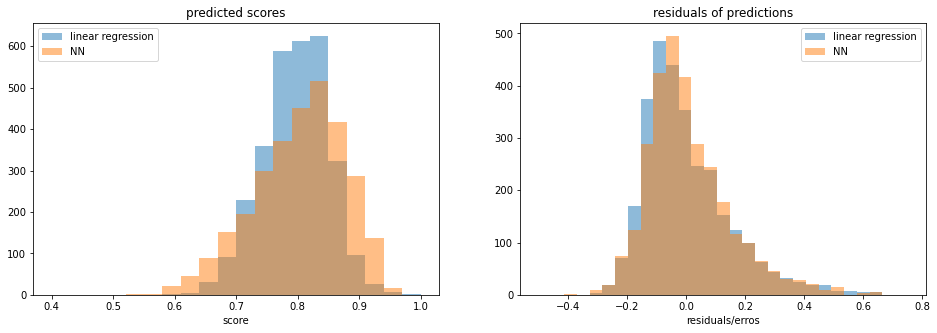

In [859]:
bins = np.linspace(0.4,1,21)
bins2 = np.linspace(-0.5,0.75,30)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 5))
ax1.hist(y_pred, bins, alpha=0.5, label="linear regression")
ax1.hist(y_pred_NN.cpu().numpy().reshape(-1), bins, alpha=0.5, label="NN")
ax1.legend()
ax1.set_title("predicted scores")
ax1.set_xlabel("score")
ax2.hist(y_pred-y_test, bins2, alpha=0.5, label="linear regression")
ax2.hist(y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score, bins2, alpha=0.5, label="NN")
ax2.legend()
ax2.set_title("residuals of predictions")
ax2.set_xlabel("residuals/erros")